# Mount drive (colab)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/visiope
!rm -rf vp_project
!git clone https://github.com/fabioscap/vp_project
%cd vp_project

# Show examples

#### Load sample photos

In [1]:
import utils
import torch
import torchvision
from torch.utils.data import DataLoader

p = (0.01,0.05) # remove 95% to 99% of depth values
depth_sampling = lambda x: utils.sample_depth_random(x,p)
depth_transform = torchvision.transforms.Lambda(depth_sampling) # depth sampling


samples = utils.NYUDepthV2("samples", 
                        shape=(240,320),
                        depth_transform=depth_transform,
                        )

import os
idxes = [int(file[:-4]) for file in os.listdir("samples/RGB")] # substitute for a data loader

#### Load models and weights

In [2]:
from torch import optim

import model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
big_net = model.Net1().to(device)
small_net = model.Net3(shape=(16,32,64,128)).to(device)

small_net.load_state_dict(torch.load("weights/small100.pth"))
big_net.load_state_dict(torch.load("weights/big_net_100.pth"))

b_num = sum(p.numel() for p in (small_net).parameters())
s_num = sum(p.numel() for p in (big_net).parameters())
print("big net has {} parameters".format(b_num))
print("small net has {} parameters".format(s_num))


big net has 504763 parameters
small net has 16001187 parameters


#### show predictions

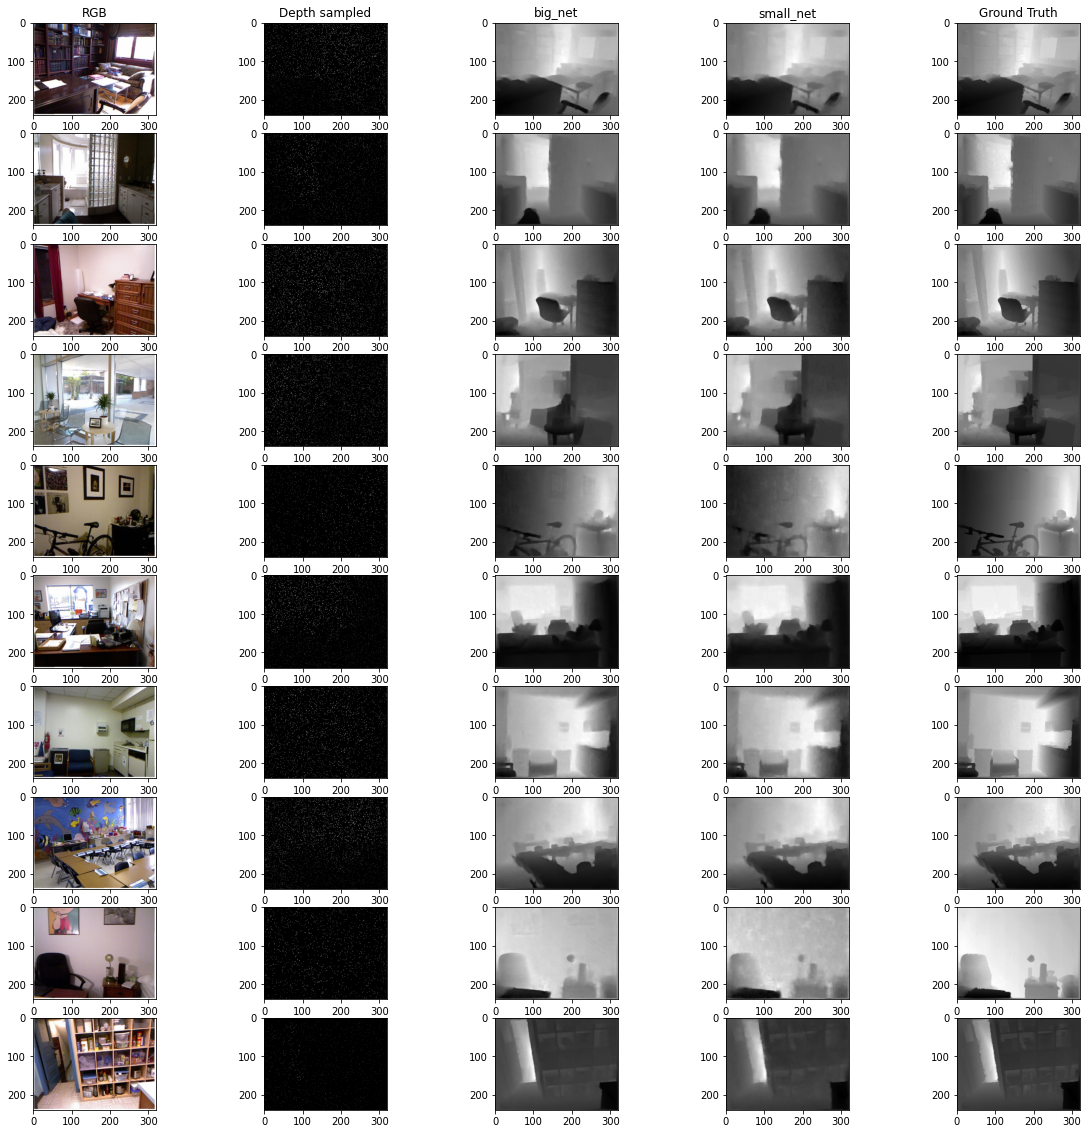

In [5]:
import matplotlib.pyplot as plt

n = 10 # n <= 10
f, axes = plt.subplots(n,5,figsize=(20,2*n))
axes[0][0].set_title("RGB")
axes[0][1].set_title("Depth sampled")
axes[0][2].set_title("big_net")
axes[0][3].set_title("small_net")
axes[0][4].set_title("Ground Truth")

with torch.no_grad():
    small_net.eval()
    big_net.eval()
    i = 0
    for i in range(n):
            batch = samples[idxes[i]]
            rgb = batch["rgb"].unsqueeze(0).to(device)
            depth = batch["depth"].unsqueeze(0).to(device)
            depth_t = batch["depth_t"].unsqueeze(0).to(device)
            out1 = big_net(rgb,depth_t)
            out2 = small_net(rgb,depth_t)
            axes[i][0].imshow(rgb.squeeze().permute(1,2,0).cpu())
            axes[i][1].imshow(depth_t.squeeze().cpu(),cmap="gray")
            axes[i][2].imshow(out1.squeeze().cpu(),cmap="gray")
            axes[i][3].imshow(out2.squeeze().cpu(),cmap="gray")
            axes[i][4].imshow(depth.squeeze().cpu(),cmap="gray")
            i += 1

#### show error map

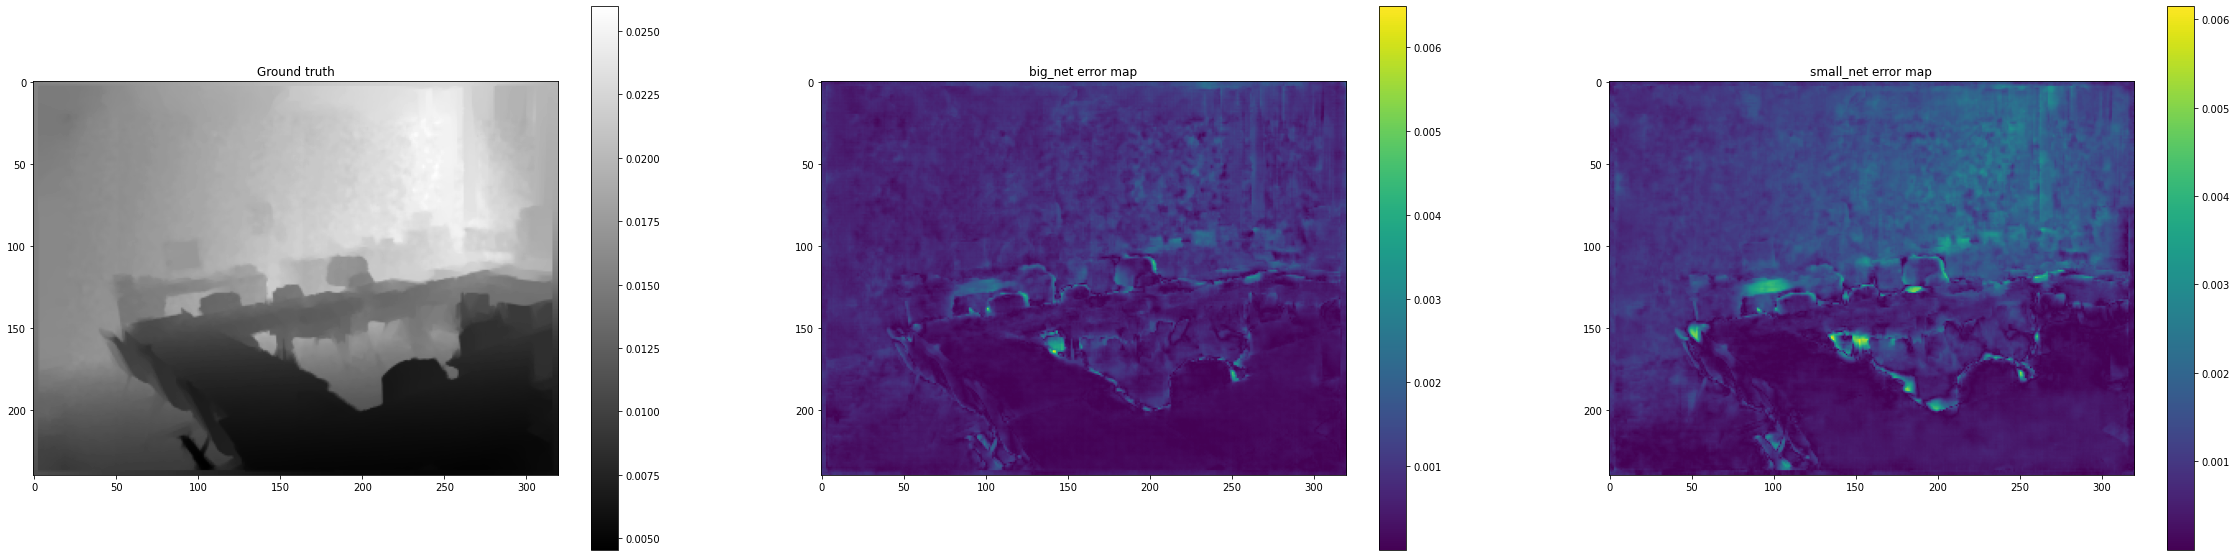

In [35]:
idx = 7
with torch.no_grad():
    small_net.eval()
    big_net.eval()
    batch = samples[idxes[idx]]
    rgb = batch["rgb"].unsqueeze(0).to(device)
    depth = batch["depth"].unsqueeze(0).to(device)
    depth_t = batch["depth_t"].unsqueeze(0).to(device)
    out1 = big_net(rgb,depth_t)
    out2 = small_net(rgb,depth_t)
    err1 = torch.abs(depth-out1)
    err2 = torch.abs(depth-out2)

f,axes = plt.subplots(1,3,figsize=(40,10))

axes[0].set_title("Ground truth")
gt = axes[0].imshow(depth.squeeze().cpu(),cmap="gray")
f.colorbar(gt, ax=axes[0],cmap="gray")

axes[1].set_title("big_net error map")
e1 = axes[1].imshow(err1.squeeze().cpu())
f.colorbar(e1, ax=axes[1])

axes[2].set_title("small_net error map")
e2 = axes[2].imshow(err2.squeeze().cpu())
f.colorbar(e2, ax=axes[2])


# Train a model

#### Load The Dataset

In [5]:
import utils
import torch
from torch.utils.data import DataLoader,random_split
import torchvision
import model

import matplotlib.pyplot as plt

from torchvision.transforms import Compose,RandomRotation,RandomHorizontalFlip

torch.manual_seed(2806)

p = (0.01,0.1) # remove 90% to 99% of depth values
depth_sampling = lambda x: utils.sample_depth_random(x,p)

common_transform = Compose([RandomHorizontalFlip(),RandomRotation(10)]) # data augmentation
depth_transform = torchvision.transforms.Lambda(depth_sampling) # depth sampling

data = utils.NYUDepthV2("../NYUDepthv2", 
                        shape=(240,320),
                        common_transform=common_transform,
                        depth_transform=depth_transform,
                        )

train_size = int(0.8*len(data))
test_size = len(data)-train_size

train_data, test_data = random_split(data,[train_size,test_size])

train_loader = DataLoader(train_data,
                    batch_size=4,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=True)

test_loader = DataLoader(test_data,
                    batch_size=1,
                    shuffle=True,
                    num_workers=4,
                    )


#### Display one sample

In [ ]:
sample = data[int(torch.rand(1).item()*len(data))]

rgb = sample["rgb"]
depth = sample["depth"]
depth_t = sample["depth_t"]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))


ax1.imshow(rgb.permute(1,2,0))
ax2.imshow(depth.squeeze(0),cmap="gray")
ax3.imshow(depth_t.squeeze(0),cmap="gray")



#### Load The Model

In [ ]:
from torch import optim

import model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = model.Net3(shape=(16,32,64,128)).to(device)

optimizer = optim.Adam(net.parameters(),lr=10**-3)

# scheduler = ...

num = sum(p.numel() for p in (net).parameters())
print("parameter number: {}".format(num))

#### Train the model

In [ ]:
bl = torch.tensor([1.,2,1])
dif = torch.tensor([1.,0,-1])
Sx = torch.einsum("i,j->ij",bl,dif).reshape((1,1,3,3)).to(device) # outer product
Sy = torch.einsum("i,j->ji",bl,dif).reshape((1,1,3,3)).to(device)

loss = lambda predicted,true: utils.rmse(predicted,true) + 0.1*utils.edge_loss(predicted,true,Sx,Sy)

utils.train(model=net,
            n_epochs = 30,
            loss_fn = loss,
            optimizer= optimizer,
            device = device,
            loader = train_loader,
            log=True)

#### Show a prediction

In [6]:
sample = next(iter(test_loader))
rgb = sample["rgb"].to(device)
depth = sample["depth"].to(device)
depth_t = sample["depth_t"].to(device)

with torch.no_grad():
    net.eval()
    out = net(rgb,depth_t).squeeze(0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))

ax1.imshow(rgb[0,...].permute(1,2,0).cpu())
ax2.imshow(depth_t[0,...].squeeze().cpu(),cmap="gray")
ax3.imshow(depth[0,...].squeeze().cpu(),cmap="gray")
ax4.imshow(out.detach()[0,...].squeeze().cpu(),cmap="gray")

NameError: name 'net' is not defined

#### load/save weights

In [ ]:
torch.save(net.state_dict(),"weights/small100_.pth")

In [ ]:
net.load_state_dict(torch.load("weights/small100.pth"))

#### Accuracy

In [ ]:
utils.compute_accuracy(net,utils.d_accuracy,test_loader,device)

In [ ]:
with torch.no_grad():
    